In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.text import *
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re,string,unicodedata
from bs4 import BeautifulSoup

# Load in Dataset

In [4]:
path = Path('data')

In [ ]:
df = pd.read_json(path/"Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

# Preprocessing and Visualization

Inspired by https://www.kaggle.com/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy

In [ ]:
df.isna().sum() # Checking for NaN values

In [ ]:
del df['article_link'] # Deleting this column as it is of no use

In [ ]:
df.head()

In [ ]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

### Remove stopwords

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [ ]:
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

In [ ]:
df.head()

### Number of Words in each class

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

### Average word length in each class

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

### Write to csv for Language Model

In [ ]:
df.head()
df.to_csv('data_lm.csv', index=True)  

# Load dataframe into Fastai data bunch

In [ ]:
bs=10

In [ ]:
data = (TextList.from_df(df, '.', cols='headline')
                .split_by_rand_pct() #randomly split with the default 20% in valid
                .label_from_df(cols=0)
                .databunch(bs=bs))

In [ ]:
data.show_batch()

In [ ]:
data.c #number of classes

# Train Langauge Model

In [8]:
bs=10

In [5]:
data_lm = (TextList.from_csv(path, './data_lm.csv', cols='headline')
                .split_by_rand_pct() #randomly split with the default 20% in valid
                .label_from_df(cols=0)
                .label_for_lm()          
                .databunch(bs=10))

/usr/local/lib/python3.7/site-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
16463, 16103, 21056, 23362, 23509...
  if getattr(ds, 'warn', False): warn(ds.warn)


In [6]:
data_lm.save('data_lm.pkl')

In [9]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [10]:
data_lm.show_batch()

idx,text
0,xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk ] xxbos [ 2 xxunk xxunk xxunk xxunk xxunk 0 xxunk xxunk xxunk ] xxbos [ 2 xxunk 88 70 xxunk ] xxbos [ 2 xxunk xxunk xxunk xxunk xxunk 9 xxunk xxunk xxunk 9 ] xxbos [ 2 70 0 xxunk 0 xxunk ] xxbos [ 2 xxunk xxunk xxunk 87 43 xxunk xxunk xxunk 10 xxunk xxunk 0 ] xxbos
1,xxunk 0 9 0 xxunk ] xxbos [ 2 xxunk xxunk 0 xxunk 12 20 xxunk ] xxbos [ 2 xxunk 12 xxunk xxunk xxunk 12 xxunk 10 xxunk xxunk xxunk 0 ] xxbos [ 2 0 33 ] xxbos [ 2 xxunk xxunk xxunk xxunk xxunk ] xxbos [ 2 xxunk xxunk xxunk xxunk 0 0 xxunk 0 ] xxbos [ 2 xxunk xxunk 13 xxunk xxunk 9 xxunk
2,xxunk xxunk xxunk 11 xxunk xxunk ] xxbos [ 2 xxunk xxunk xxunk xxunk xxunk 13 9 xxunk xxunk 9 ] xxbos [ 2 26 0 xxunk 0 90 xxunk xxunk ] xxbos [ 2 xxunk xxunk xxunk xxunk xxunk 22 16 10 xxunk xxunk ] xxbos [ 2 0 0 10 xxunk xxunk 0 0 xxunk xxunk ] xxbos [ 2 xxunk xxunk 0 xxunk xxunk 0 ] xxbos
3,xxunk xxunk xxunk 11 xxunk ] xxbos [ 2 xxunk xxunk xxunk xxunk 26 xxunk xxunk xxunk xxunk xxunk ] xxbos [ 2 xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk ] xxbos [ 2 xxunk xxunk 39 xxunk xxunk ] xxbos [ 2 58 43 xxunk xxunk xxunk 49 41 0 35 ] xxbos [ 2 xxunk 70 36 xxunk xxunk ] xxbos [ 2 34 10 xxunk xxunk
4,] xxbos [ 2 xxunk 69 xxunk xxunk xxunk xxunk xxunk ] xxbos [ 2 xxunk xxunk xxunk xxunk 0 xxunk 0 0 ] xxbos [ 2 xxunk xxunk 13 0 xxunk 0 18 ] xxbos [ 2 xxunk xxunk xxunk xxunk xxunk xxunk 63 xxunk xxunk ] xxbos [ 2 xxunk 16 0 xxunk xxunk xxunk xxunk xxunk xxunk ] xxbos [ 2 xxunk xxunk xxunk xxunk 10 xxunk


In [11]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


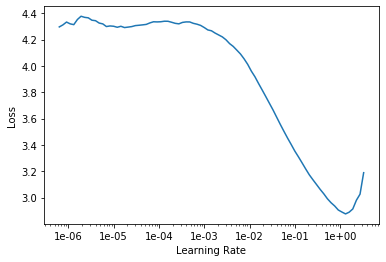

In [13]:
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "Donald trump once again "
N_WORDS = 10
N_SENTENCES = 1

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

### Save the Encoder
The first half of the Language Model that Understands the Sentence 

In [ ]:
learn.save_encoder('fine_tuned_enc')

# Train Classifier Model

Important to load in the language model vocab

In [ ]:
data_classifier = (TextList.from_csv(path, './title_labeled.csv', cols='text', vocab=data_lm.vocab)
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch(bs=bs))
data_classifier.save('data_classifier.pkl')

In [ ]:
data_classifier = load_data(path, 'data_classifier.pkl', bs=bs)

In [ ]:
data_classifier.show_batch()

In [ ]:
learn = text_classifier_learner(data_classifier, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc');

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))